In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_20newsgroups
import torch
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import torch
import umap
from sklearn.svm import SVC
import tools as tl 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:

# # Function to generate embeddings
# def generate_embeddings(texts, tokenizer, model, batch_size=16):
#     """
#     Generate embeddings for a list of texts using DistilRoBERTa with mean pooling.
#     """
#     embeddings = []
#     # Wrap the loop with tqdm for a progress bar
#     for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings", unit="batch"):
#         batch = texts[i:i + batch_size]
#         inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)

#         with torch.no_grad():
#             outputs = model(**inputs)
#             # Use mean pooling for sentence representation
#             attention_mask = inputs['attention_mask']
#             token_embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)

#             # Compute mean of embeddings, taking into account the attention mask
#             masked_embeddings = token_embeddings * attention_mask.unsqueeze(-1)  # Shape: (batch_size, seq_length, hidden_size)
#             sum_embeddings = masked_embeddings.sum(dim=1)  # Shape: (batch_size, hidden_size)
#             count_embeddings = attention_mask.sum(dim=1)  # Shape: (batch_size)

#             # Avoid division by zero and compute mean
#             mean_embeddings = sum_embeddings / count_embeddings.unsqueeze(-1).clamp(min=1e-9)  # Shape: (batch_size, hidden_size)
#             embeddings.append(mean_embeddings)
#     return torch.cat(embeddings, dim=0)

# def reduce_dimensionality(embeddings, n_components=300, algo='none'):
#     """
#     Reduce the dimensionality of embeddings using PCA.
#     """
#     if algo == 'pca':
#         pca = PCA(n_components=n_components)
#         reduced_embeddings = pca.fit_transform(embeddings.cpu().numpy())
#     elif algo == 'umap':
#         reducer = umap.UMAP(n_components=n_components)
#         reduced_embeddings = reducer.fit_transform(embeddings.cpu().numpy())
#     elif algo == 'none':
#         reduced_embeddings = embeddings.cpu().numpy()
#     return reduced_embeddings

In [4]:
# Load the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

df_train = pd.DataFrame({'text': newsgroups_train.data, 'label': newsgroups_train.target})
df_test = pd.DataFrame({'text': newsgroups_test.data, 'label': newsgroups_test.target})

df_train['label'] = df_train['label'].map(lambda x: newsgroups_train.target_names[x])
df_test['label'] = df_test['label'].map(lambda x: newsgroups_test.target_names[x])

df_train = df_train[df_train['label'].isin(['rec.sport.baseball', 'comp.graphics', 'sci.space', 'talk.religion.misc'])]
df_test = df_test[df_test['label'].isin(['rec.sport.baseball', 'comp.graphics', 'sci.space', 'talk.religion.misc'])]


In [5]:
len(df_train), len(df_test)

(2151, 1431)

In [6]:
df_train = df_train.sample(300)
df_test = df_test.sample(100)
len(df_train), len(df_test)

(300, 100)

In [7]:
# Initialize distilroberta tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
model = RobertaModel.from_pretrained('distilroberta-base')
# Generate embeddings
print("Generating embeddings...")
embeddings_train = tl.generate_embeddings(df_train['text'].tolist(), tokenizer, model)
embeddings_test = tl.generate_embeddings(df_test['text'].tolist(), tokenizer, model)
print("Embeddings generated!")

Generating embeddings...


Generating Embeddings: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s]

Embeddings generated!


In [8]:
print("Reducing dimensionality...")
reduction_algo = 'none'
reduced_embeddings_train = tl.reduce_dimensionality(embeddings_train, algo=reduction_algo, n_components=50)
reduced_embeddings_test = tl.reduce_dimensionality(embeddings_test, algo=reduction_algo, n_components=50)
print("Complete")

# Fit an SVM model to the reduced embeddings
svm_model = SVC(kernel='linear')
svm_model.fit(reduced_embeddings_train, df_train['label'])

# Predict the labels
predicted_labels = svm_model.predict(reduced_embeddings_test)

# Add the predicted labels to the dataframe
df_test['cluster'] = predicted_labels

Reducing dimensionality...
Complete


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(df_test['label'], df_test['cluster'], average='weighted')
print(f"Precision: {precision * 100:.2f}%")

# Calculate recall
recall = recall_score(df_test['label'], df_test['cluster'], average='weighted')
print(f"Recall: {recall * 100:.2f}%")

# Calculate F1 score
f1 = f1_score(df_test['label'], df_test['cluster'], average='weighted')
print(f"F1 Score: {f1 * 100:.2f}%")

Precision: 79.38%
Recall: 79.00%
F1 Score: 79.11%


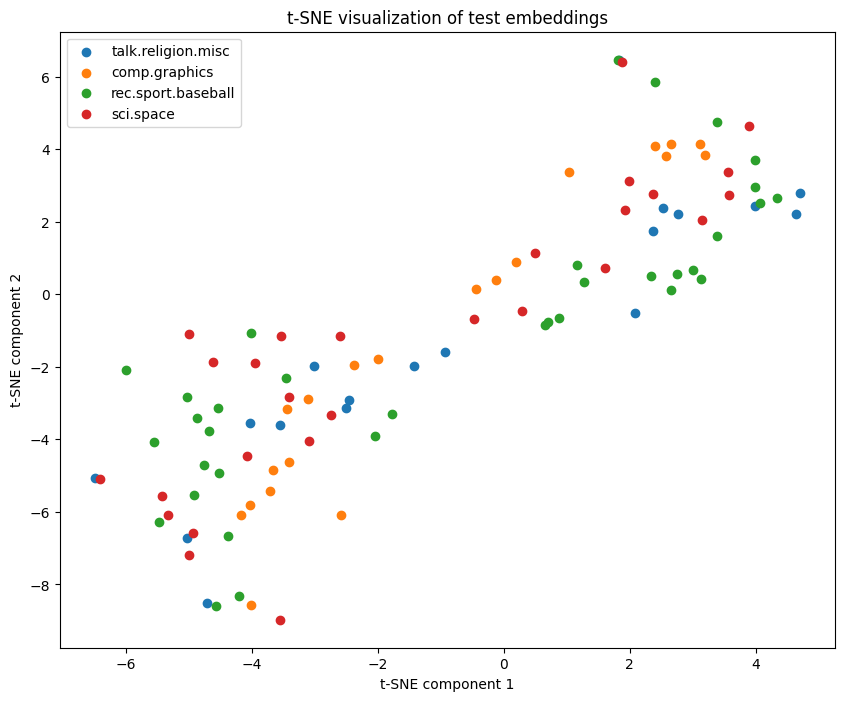

In [10]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(reduced_embeddings_test)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
for label in df_test['label'].unique():
    indices = df_test['label'] == label
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], label=label)

plt.legend()
plt.title('t-SNE visualization of test embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()